In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

1. We'll make a classifier for MNIST dataset in pytorch using CNN architecture


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

# Downloading the dataset

In [8]:
train_transforms = transforms.Compose([
                        # transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

train_dataset = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)
val_dataset = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 182865323.01it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30497405.29it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41202317.50it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21027073.70it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [9]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 60000
Length of val_dataset is 60000


In [10]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize the images and it's channels

torch.Size([1, 250, 250])
Number of channels in test_image:  1


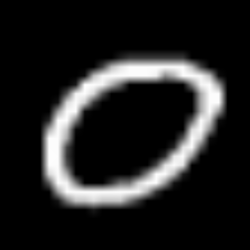

In [17]:
random_img_idx = torch.randint(0, 1000, (1,)).item()

test_image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print(test_image.shape)
print('Number of channels in test_image: ', test_image.shape[0])
to_pil_image(test_image)

In [53]:
class MNISTClassifier(nn.Module):
  def __init__(self):
    super(MNISTClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1,  32, 3, 1, 1) # in_channels, out_channels, kernel_size, stride=1, padding=0,
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)

    self.linear1 = nn.Linear(64 * 7 * 7,100)
    self.linear2 = nn.Linear(100, 100)

  def forward(self, x):
    # x ---> (bs, 1, 28, 28)
    x1 = torch.relu(self.conv1(x))
    # x ---> (bs, 32, 28, 28)
    x = F.max_pool2d(x1, 2)
    # x ---> (bs, 1, 14, 14)
    x2 = torch.relu(self.conv2(x))
    # x ---> (bs, 64, 14, 14)
    x = F.max_pool2d(x2, 2)
    # x ---> (bs, 64, 7, 7)

    # x ---> (bs, 64 * 7 * 7)
    x = x.view(-1, 64 * 7 * 7)
    x = torch.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
model = MNISTClassifier().to(device)

In [58]:
num_epochs = 10
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cuda


In [59]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)
    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.027076501986943186, val_loss=0.022155284044689808. labelled 59621/60000 correctly (99.36833333333334% accuracy)
Epoch: 1, train_loss=0.02502590881890307, val_loss=0.02398544855651756. labelled 59549/60000 correctly (99.24833333333333% accuracy)
Epoch: 2, train_loss=0.023653547119659682, val_loss=0.020572034995863214. labelled 59625/60000 correctly (99.375% accuracy)
Epoch: 3, train_loss=0.022228100162247817, val_loss=0.017024245231032062. labelled 59730/60000 correctly (99.55000000000001% accuracy)
Epoch: 4, train_loss=0.020591297678525248, val_loss=0.017151062302174978. labelled 59695/60000 correctly (99.49166666666667% accuracy)
Epoch: 5, train_loss=0.018776542184400995, val_loss=0.016483893865393475. labelled 59699/60000 correctly (99.49833333333333% accuracy)
Epoch: 6, train_loss=0.017756229365585994, val_loss=0.013853308655096529. labelled 59781/60000 correctly (99.63499999999999% accuracy)
Epoch: 7, train_loss=0.01685256873006001, val_loss=0.013124461585562

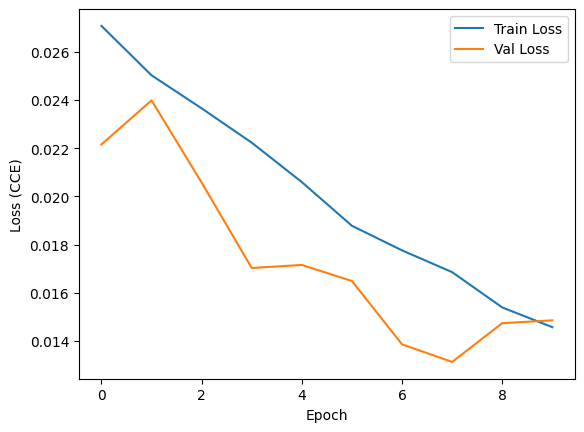

In [60]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()